In [5]:
from time import time 

import jax.lax as lax
import jax.numpy as jnp
import jax.random as random
from jax import grad, value_and_grad, vmap, jit
import equinox as eqx
import optax
import matplotlib.pyplot as plt

from playground_jax.models_equinox import *

In [6]:
# set a random key
key = random.PRNGKey(seed=1)

In [3]:
# parameters
d = 1
dt = 0.01
K = 100
N = 100
x_init = 0 * jnp.ones((K, d))
r_lim = 1

1. Build a model

In [7]:
# model
key, subkey = random.split(key)
model = MLP_4layers(d_in=d, d_out=d, d_hidden=[32, 32, 32], key=subkey)

# evaluation data
x = jnp.expand_dims(jnp.linspace(-1, 1, 101), axis=-1)
y_init = vmap(model)(x)

2. Define optimization routine 

In [8]:
lr = 1e-2
opt = optax.adam(learning_rate=lr)
opt_state = opt.init(model)

3. Define loss

In [9]:
def loss_fn(model, key):

    def apply_fn(state):
    
        # unpack values
        xt, det_int, key = state
        d = xt.shape[0]

        # brownian motion
        key, subkey = random.split(key)
        eta = random.normal(key, (d,))     

        # sde update
        xt = xt + jnp.sqrt(dt) * eta

        # det girsanov integral
        u = model(xt)
        det_int = det_int + (jnp.linalg.norm(u) ** 2) * dt
    
        return xt, det_int, key

    def body_fn_loop(i, state):
        return apply_fn(state)

    def sample_fn_loop(x_init, key):
        return lax.fori_loop(0, N, body_fn_loop, (x_init, 0., key))

    def body_fn_scan(state, x):
        state = apply_fn(state)
        return state, None

    def sample_fn_scan(x_init, key):
        return lax.scan(body_fn_scan, init=(x_init, 0., key), xs=None, length=N)
        
    #sample_fn_loop = vmap(sample_fn_loop, in_axes=(0, 0), out_axes=0)
    sample_fn_scan = vmap(sample_fn_scan, in_axes=(0, 0), out_axes=0)        
    subkeys = random.split(key, K)
    #xt, det_int, key = sample_fn_loop(x_init, subkeys)
    (xt, det_int, key), _ = sample_fn_scan(x_init, subkeys)
    return det_int.mean(), (xt, key)

loss_fn = jit(loss_fn)

4. Update function

In [10]:
@jit
def update_fn(model, opt_state, key):
    
    # compute gradients and loss value
    (loss, data), grads = value_and_grad(loss_fn, has_aux=True)(model, key)

    # optimizer upate
    updates, opt_state = opt.update(grads, opt_state)
    model = optax.apply_updates(model, updates)
    return loss, model, opt_state

5. Train

In [11]:
n_iter = int(1e1)
log_period_iter = int(1e1)
for i in range(n_iter):
    t0 = time()
    loss, model, opt_state = update_fn(model, opt_state, key)
    t1 = time()
    if i % log_period_iter == 0: 
        print('it: {:d}, loss: {:.3e}, time: {:.4f}s'.format(i, loss, t1-t0))

it: 0, loss: 9.103e-02, time: 0.7123s


6. Evaluate

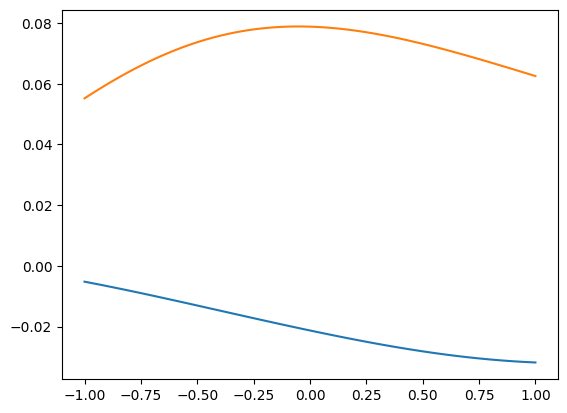

In [54]:
y_final = vmap(model)(x)
fig, ax = plt.subplots()
ax.plot(x, y_init)
ax.plot(x, y_final)